# Programming Exercise 6: Support Vector Machines

In [1]:
%matplotlib inline
from math import *
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.io import loadmat
from sklearn.svm import SVC
from nltk import PorterStemmer

## 1. Support Vector Machines

### 1.1 Example Dataset 1

In [2]:
data1 = loadmat('machine-learning-ex6/ex6/ex6data1.mat')
globals().update(data1)
print(X.shape)
print(y.shape)

(51, 2)
(51, 1)


In [3]:
def plotData(X, y):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*np.hsplit(X[np.where(y == 1)[0]], 2), c='k', marker='+')
    ax.scatter(*np.hsplit(X[np.where(y == 0)[0]], 2), c='y', marker='o')
    return fig, ax

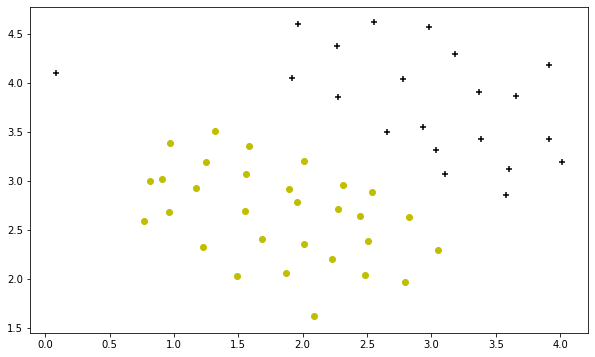

In [4]:
origin = plotData(X, y)

In [5]:
def visualizeBoundary(X, y, model):
    fig, ax = plotData(X, y)
    x1_min, x2_min = np.min(X, axis=0)
    x1_max, x2_max = np.max(X, axis=0)
    x1plot = np.linspace(x1_min, x1_max, 100)
    x2plot = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)
    Z = model.predict(np.column_stack((X1.ravel(), X2.ravel()))).reshape(X1.shape)
    ax.contour(x1plot, x2plot, Z, levels=[0], c="b")
    return fig, ax

In [6]:
def svmTrain(X, y, C, kernelFunction='linear', **kargs):
    clf = SVC(C=C, kernel=kernelFunction, **kargs)
    clf.fit(X, y.ravel())
    return clf

In [7]:
# C plays a role similar to 1/λ, where λ is the regularization parameter
def try_different_C(C):
    model = svmTrain(X, y, C)
    fig, ax = visualizeBoundary(X, y, model)
    ax.set_title(f"SVM Decision Boundary with C={C}")

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':
/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'c'
  if __name__ == '__main__':


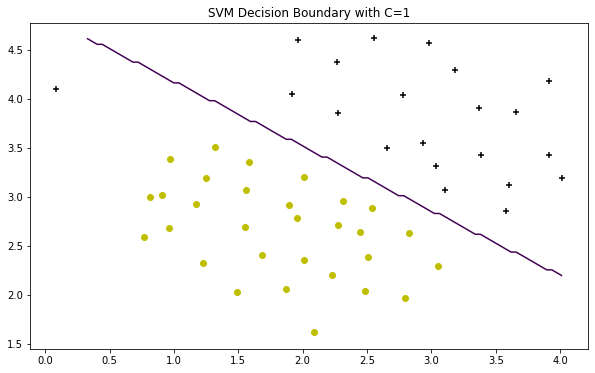

In [8]:
try_different_C(1)

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':
/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'c'
  if __name__ == '__main__':


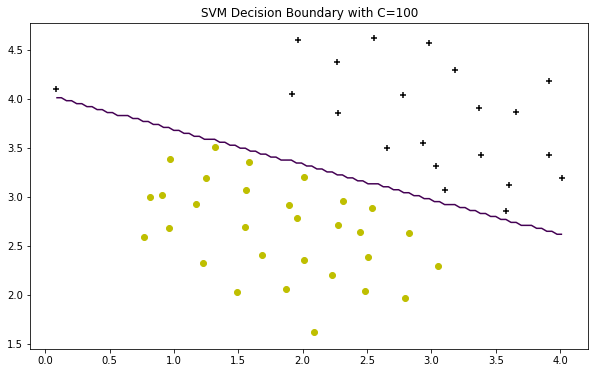

In [9]:
# SVM now classifies every single example correctly,
# but has a decision boundary that does not appear to be a natural fit for the data
try_different_C(100)

### 1.2 SVM with Gausssian Kernels

#### 1.2.1 Gaussian Kernel

 You can think of the Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, $(x^{(i)},x^{(j)})$. The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.

$$
K_{gaussian}(x^{(i)},x^{(j)}) = exp\bigg(- \frac{\lVert x^{(i)} - x^{(j)}\rVert^{2}}{2\sigma^{2}}\bigg) = exp\bigg(- \frac{\sum^{n}_{k=1}\big(x^{(i)}_{k} - x^{(j)}_{k}\big)^{2}}{2\sigma^{2}}\bigg)
$$

In [10]:
def gaussianKernel(x1, x2, sigma):
    norm = np.sum(np.square(x1 - x2))
    return exp(-norm / (2 * sigma ** 2))

In [11]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, - 1])
sigma = 2
sim = gaussianKernel(x1, x2, sigma)

np.testing.assert_approx_equal(sim, 0.324652, significant=6, err_msg="this value should be about 0.324652")
print(f"Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = {sigma} is {sim}")

Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2 is 0.32465246735834974


#### 1.2.2 Example Dataset 2

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3d59df160>)

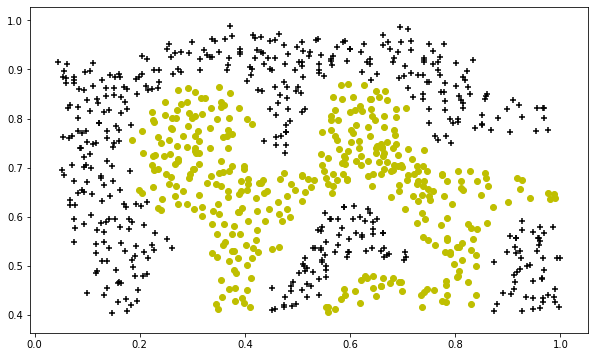

In [12]:
data2 = loadmat('machine-learning-ex6/ex6/ex6data2.mat')
globals().update(data2)
plotData(X, y)

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':
/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'c'
  if __name__ == '__main__':


(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3d5959518>)

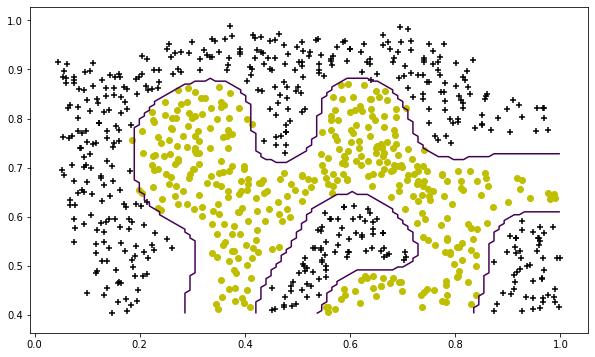

In [13]:
# gamma = 1/ (2 * sigma^2)
model = svmTrain(X, y, C=1, kernelFunction="rbf", gamma=pow(0.1, -2))
visualizeBoundary(X, y, model)

#### 1.2.3 Example Dataset 3

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3d58ad080>)

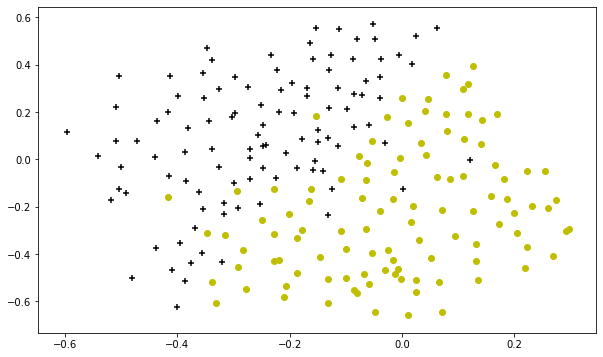

In [14]:
data3 = loadmat('machine-learning-ex6/ex6/ex6data3.mat')
globals().update(data3)
plotData(X, y)

In [15]:
def dataset3Params(X, y, Xval, yval):
    scores = []
    for C in np.logspace(-4, 3, 10, base=10 / 3):
        for sigma in np.logspace(-4, 3, 10, base=10 / 3):
            gamma = pow(sigma, -2) / 2
            model = svmTrain(X, y, C=C, kernelFunction="rbf", gamma=gamma)
            scores.append((model.score(Xval, yval), model.score(X, y), (C, sigma)))
    scores.sort(key=lambda x: (x[0], x[1]), reverse=True)
    return scores[0][2]

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':
/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'c'
  if __name__ == '__main__':


(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3d5838048>)

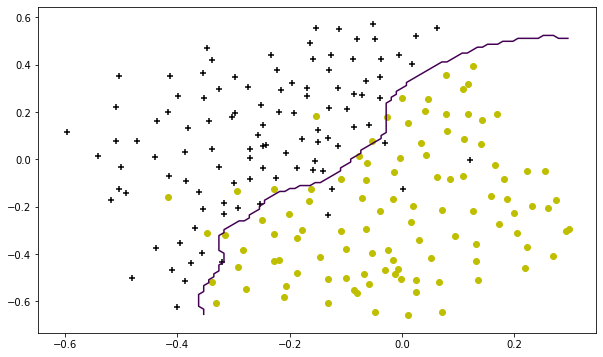

In [16]:
# Your task is to use the cross validation set Xval, yval 
# to determine the best C and σ parameter to use
C, sigma = dataset3Params(X, y, Xval, yval)

model = svmTrain(X, y, C=C, kernelFunction="rbf", gamma=pow(sigma, -2))
visualizeBoundary(X, y, model)

## 2 Spam Classification

### 2.1 Preprocessing Emails

### 2.1.1 Vocabulary List

In the function processEmail below, we have implemented the following email preprocessing and normalization steps:

* Lower-casing: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

* Stripping HTML: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

* Normalizing URLs: All URLs are replaced with the text “httpaddr”.

* Normalizing Email Addresses: All email addresses are replaced with the text “emailaddr”.

* Normalizing Numbers: All numbers are replaced with the text “number”.

* Normalizing Dollars: All dollar signs (\\$) are replaced with the text “dollar”.

* Word Stemming: Words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.

* Removal of non-words: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

In [17]:
def getVocabList():
    """reads the fixed vocabulary list in vocab.txt and returns a
    cell array of the words
    """
    
    with open('./machine-learning-ex6/ex6/vocab.txt', 'r') as vocabFile:
        vocabList = {}
        for line in vocabFile.readlines():
            i, word = line.split()
            vocabList[word] = int(i)

    return vocabList

def processEmail(email_contents):
    """preprocesses a the body of an email and
    returns a list of word_indices 
    """
    vocabList = getVocabList()

    # Init return value
    word_indices = []

    # ========================== Preprocess Email ===========================

    # Find the Headers ( \n\n and remove )
    # Uncomment the following lines if you are working with raw emails with the
    # full headers

    # hdrstart = email_contents.find("\n\n")
    # if hdrstart:
    #     email_contents = email_contents[hdrstart:]

    # Lower case
    email_contents = email_contents.lower()

    # Strip all HTML
    # Looks for any expression that 
    # - starts with < and ends with >, &
    # - does not have any < or > in the tag 
    # and replace it with a space 
    email_contents = re.sub('<[^<>]+>', ' ', email_contents)

    # Handle Numbers
    # Look for one or more characters between 0-9 and replace it with 'number'
    email_contents = re.sub('[0-9]+', 'number', email_contents)

    # Handle URLS
    # Look for strings starting with http:// or https://
    # and replace with 'httpaddr'
    email_contents = re.sub('(http|https)://[^\s]*', 'httpaddr', email_contents)

    # Handle Email Addresses
    # Look for strings with @ in the middle
    # and replace with 'emailaddr'
    email_contents = re.sub('[^\s]+@[^\s]+', 'emailaddr', email_contents)

    # Handle $ sign
    # replace with 'dollar'
    email_contents = re.sub('[$]+', 'dollar', email_contents)

    l = 0

    # Split and also get rid of any punctuation
    # regex may need further debugging...
    email_contents = re.split(r'[@$/#.-:&\*\+=\[\]?!(){},\'\'\">_<;%\s\n\r\t]+', email_contents)

    for token in email_contents:

        # Remove any non alphanumeric characters
        token = re.sub('[^a-zA-Z0-9]', '', token)

        # Stem the word 
        token = PorterStemmer().stem(token.strip())

        # Skip the word if it is too short
        if len(token) < 1:
           continue

        # Look up the word in the dictionary and add to word_indices if found
        idx = vocabList[token] if token in vocabList else 0

        # only add entries which are in vocabList
        #   i.e. those with ind ~= 0, 
        #        given that ind is assigned 0 if str is not found in vocabList
        if idx > 0:
            word_indices.append(idx)

    return word_indices

In [18]:
# Preprocessing sample email (emailSample1.txt)
# Extract Features
vocablist = getVocabList()
file_contents = open('./machine-learning-ex6/ex6/emailSample1.txt', "r").read()
word_indices = processEmail(file_contents)
np.testing.assert_equal(word_indices, np.array([
    86,   916,  794,  1077, 883,
    370,  1699, 790,  1822,
    1831, 883,  431,  1171,
    794,  1002, 1893, 1364,
    592,  1676, 238,  162,  89,
    688,  945,  1663, 1120,
    1062, 1699, 375,  1162,
    479,  1893, 1510, 799,
    1182, 1237, 810,  1895,
    1440, 1547, 181,  1699,
    1758, 1896, 688,  1676,
    992,  961,  1477, 71,   530,
    1699, 531
]))

### 2.2 Extracting Features from Emails

You will now implement the feature extraction that converts each email into a vector in $R^n$. The feature $x_i \in \{0, 1\}$ for an email corresponds to whether the i-th word in the dictionary occurs in the email.

In [19]:
def emailFeatures(word_indices):
    """takes in a word_indices vector and produces a feature vector
    from the word indices"""
    n = 1899
    x = np.zeros((n, 1))
    print(word_indices)
    x[word_indices] = 1
    return x

You should see that the feature vector had length 1899 and 45 non-zero entries.

In [20]:
file_contents = open('./machine-learning-ex6/ex6/emailSample1.txt').read()
word_indices  = processEmail(file_contents)
features      = emailFeatures(word_indices)

print('Length of feature vector: {:d}'.format( len(features) ) )
print('Number of non-zero entries: {:d}'.format( np.sum(features > 0) ) )

[86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1893, 1364, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]
Length of feature vector: 1899
Number of non-zero entries: 45


### 2.3 Training SVM for Spam Classification

In [21]:
mat = scipy.io.loadmat('./machine-learning-ex6/ex6/spamTrain.mat')
X = mat["X"]
y = mat["y"]

print('Training Linear SVM Spam Classification (this may take 1 to 2 minutes)...')

C = 0.1
model = svmTrain(X, y, C, "linear")

Training Linear SVM Spam Classification (this may take 1 to 2 minutes)...


In [22]:
mat = scipy.io.loadmat('./machine-learning-ex6/ex6/spamTest.mat')
Xtest = mat["Xtest"]
ytest = mat["ytest"]

print('Evaluating the trained Linear SVM on a test set ...')

p = model.predict(Xtest)
print('Test Accuracy: {:f}'.format( np.mean((p == ytest.flatten()).astype(int)) * 100 ))

Evaluating the trained Linear SVM on a test set ...
Test Accuracy: 98.900000


### 2.4 Understanding a spam classifier

One advantage of using the linear kernel for our SVM is that we can peek inside the weights to better understand how it discriminates spam from non-spam email.

In [23]:
w = model.coef_[0]
indices = w.argsort()[::-1][:15]
vocabList = sorted(getVocabList().keys())

print('\nTop predictors of spam: \n');
for idx in indices: 
    print( ' {:s} ({:f}) '.format( vocabList[idx], float(w[idx]) ) )


Top predictors of spam: 

 our (0.500614) 
 click (0.465916) 
 remov (0.422869) 
 guarante (0.383622) 
 visit (0.367710) 
 basenumb (0.345064) 
 dollar (0.323632) 
 will (0.269724) 
 price (0.267298) 
 pleas (0.261169) 
 most (0.257298) 
 nbsp (0.253941) 
 lo (0.253467) 
 ga (0.248297) 
 hour (0.246404) 
